In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 读取数据
df = pd.read_csv('B题指标数据.csv')

# 数据预处理
# 分离特征数据
feature_columns = [col for col in df.columns if col not in ['city', 'year']]
X = df[feature_columns].values

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 主成分分析
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 计算贡献率和累计贡献率
explained_ratio = pca.explained_variance_ratio_
cumulative_ratio = np.cumsum(explained_ratio)

# 绘制碎石图和累计贡献率图
plt.figure(figsize=(12, 6), dpi=300)
plt.subplot(121)
plt.plot(range(1, len(explained_ratio) + 1), explained_ratio, 'ro-')
plt.title('主成分贡献率')
plt.xlabel('主成分')
plt.ylabel('贡献率')
plt.grid(True)

plt.subplot(122)
plt.plot(range(1, len(cumulative_ratio) + 1), cumulative_ratio, 'bo-')
plt.axhline(y=0.85, color='r', linestyle='--')
plt.title('主成分累计贡献率')
plt.xlabel('主成分数量')
plt.ylabel('累计贡献率')
plt.grid(True)
plt.tight_layout()
plt.savefig('问题1_主成分分析结果.png', dpi=300, bbox_inches='tight')
plt.show()

# 确定主成分个数
n_components = np.where(cumulative_ratio >= 0.85)[0][0] + 1
print(f"需要的主成分个数: {n_components}")

# 重新进行PCA，保留确定的主成分个数
pca = PCA(n_components=n_components)
X_pca_final = pca.fit_transform(X_scaled)

# 计算主成分得分
pca_scores = pd.DataFrame(X_pca_final)
pca_scores.columns = [f'PC{i+1}' for i in range(n_components)]
pca_scores['city'] = df['city']
pca_scores['year'] = df['year']

# 保存主成分得分
pca_scores.to_excel('问题1_主成分得分.xlsx', index=False)

# 计算载荷矩阵
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=feature_columns
)

# 绘制热力图显示载荷矩阵
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(loadings, cmap='RdBu', center=0, annot=True, fmt='.2f')
plt.title('主成分载荷矩阵热力图')
plt.tight_layout()
plt.savefig('问题1_主成分载荷矩阵.png', dpi=300, bbox_inches='tight')
plt.show()

# 灰色关联分析
def grey_correlation(x, y):
    """计算灰色关联度"""
    abs_diff = np.abs(x - y)
    min_diff = np.min(abs_diff)
    max_diff = np.max(abs_diff)
    rho = 0.5  # 分辨系数
    correlation = (min_diff + rho * max_diff) / (abs_diff + rho * max_diff)
    return np.mean(correlation)

# 计算各指标与GDP的灰色关联度
gdp = df['gdp'].values
grey_correlations = {}
for feature in feature_columns:
    if feature != 'gdp':
        corr = grey_correlation(gdp, df[feature].values)
        grey_correlations[feature] = corr

# 将灰色关联度转换为DataFrame并排序
grey_corr_df = pd.DataFrame.from_dict(grey_correlations, orient='index', columns=['correlation'])
grey_corr_df = grey_corr_df.sort_values('correlation', ascending=False)

# 保存灰色关联度结果
grey_corr_df.to_excel('问题1_灰色关联度.xlsx')

# 绘制灰色关联度条形图
plt.figure(figsize=(15, 8), dpi=300)
grey_corr_df['correlation'].plot(kind='bar')
plt.title('各指标与GDP的灰色关联度')
plt.xlabel('指标')
plt.ylabel('关联度')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('问题1_灰色关联度分析.png', dpi=300, bbox_inches='tight')
plt.show()
print("原创作者：B站北辰single，原创地址：https://www.yuque.com/u42168770/qv6z0d/eowuwbl8avfkbf8s")

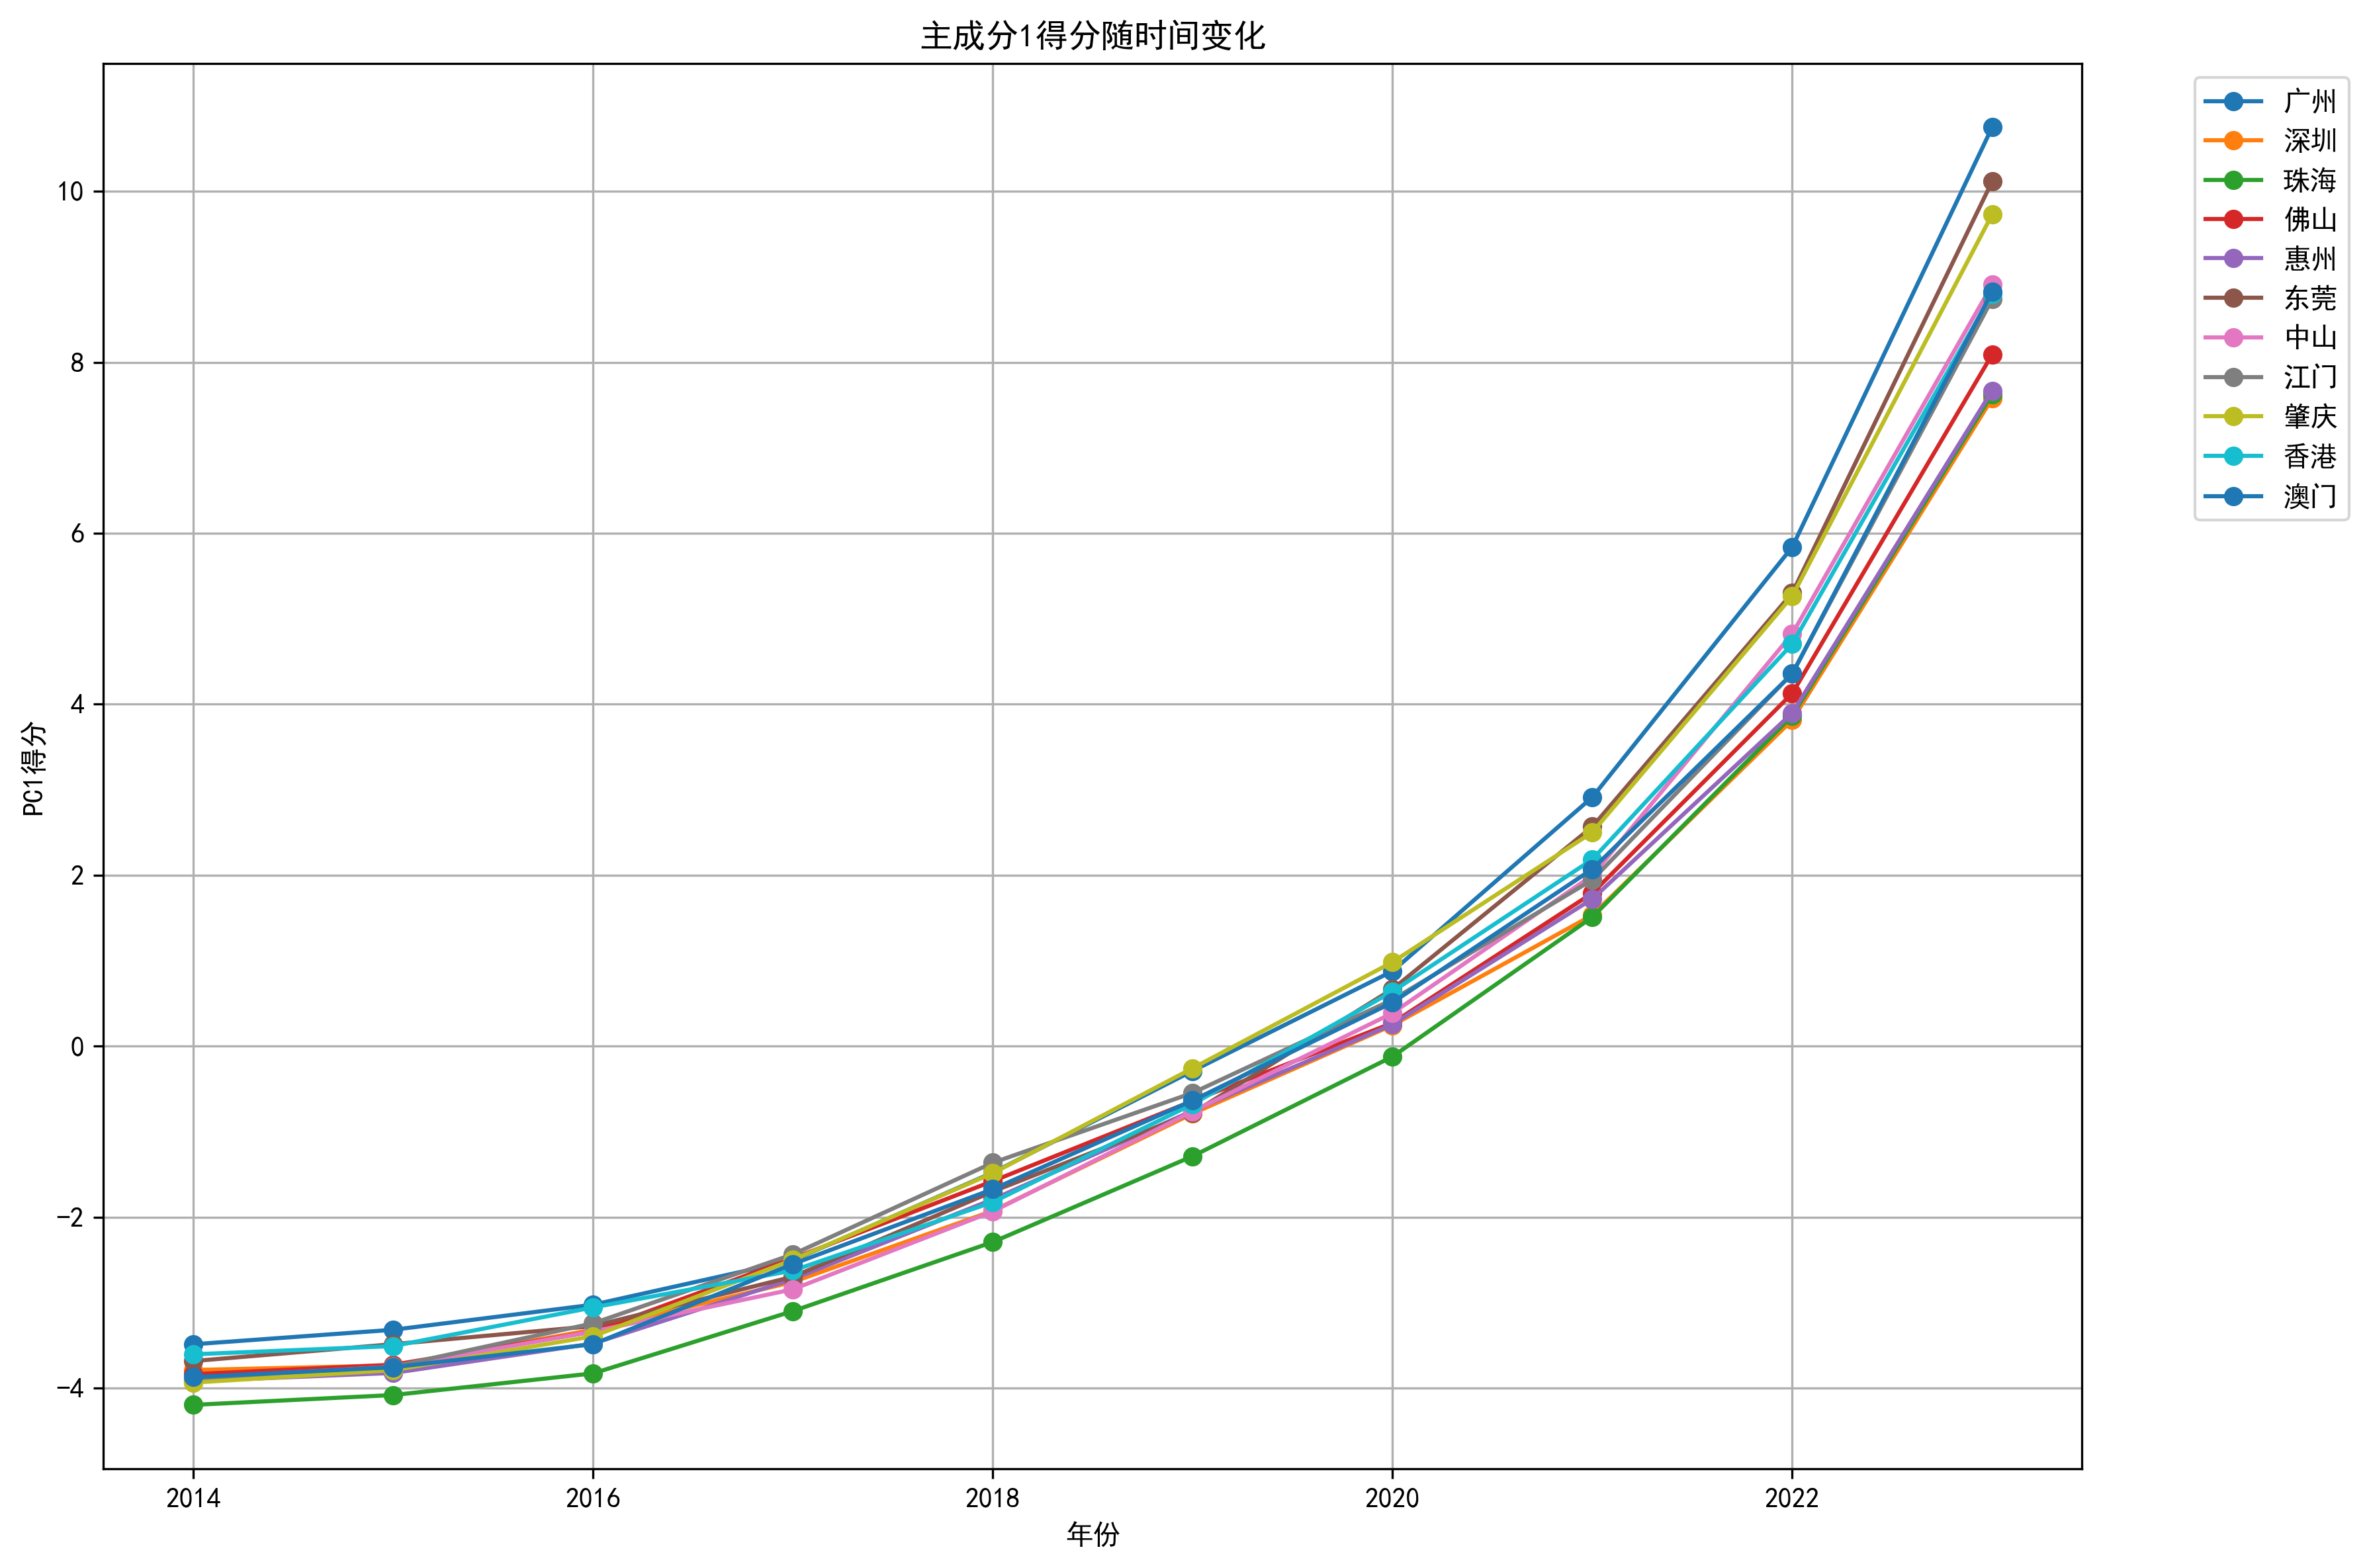

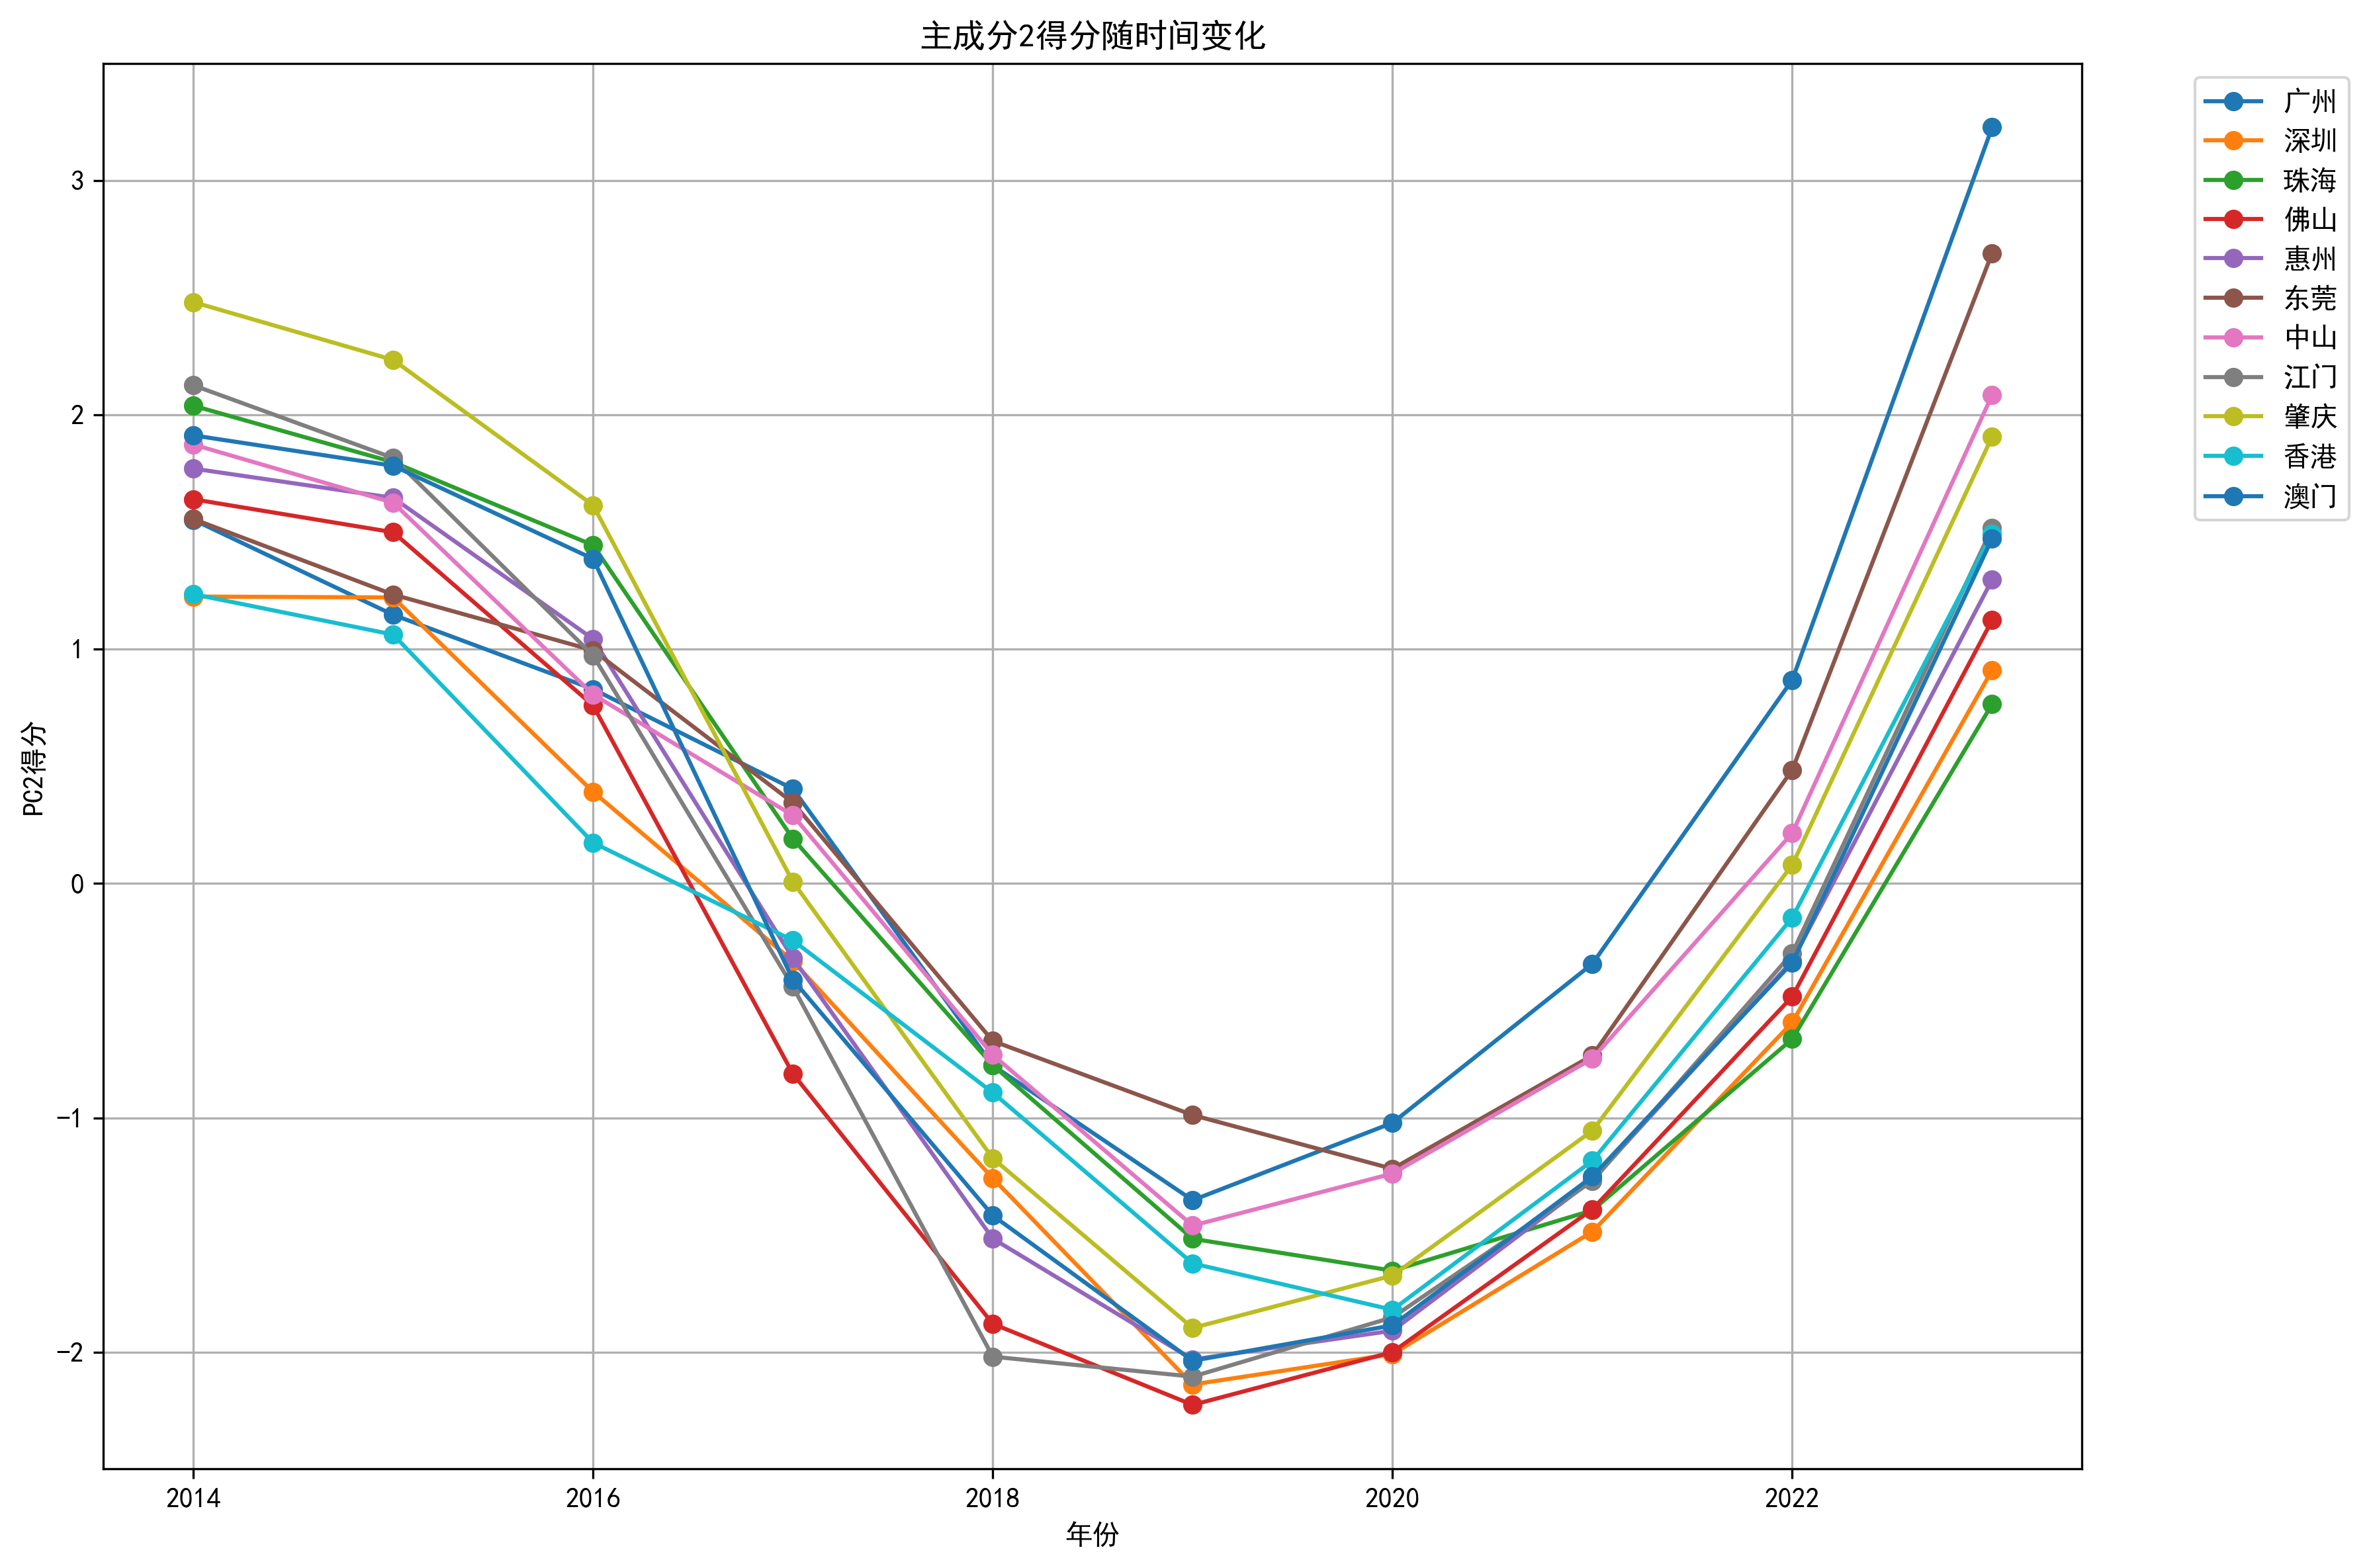

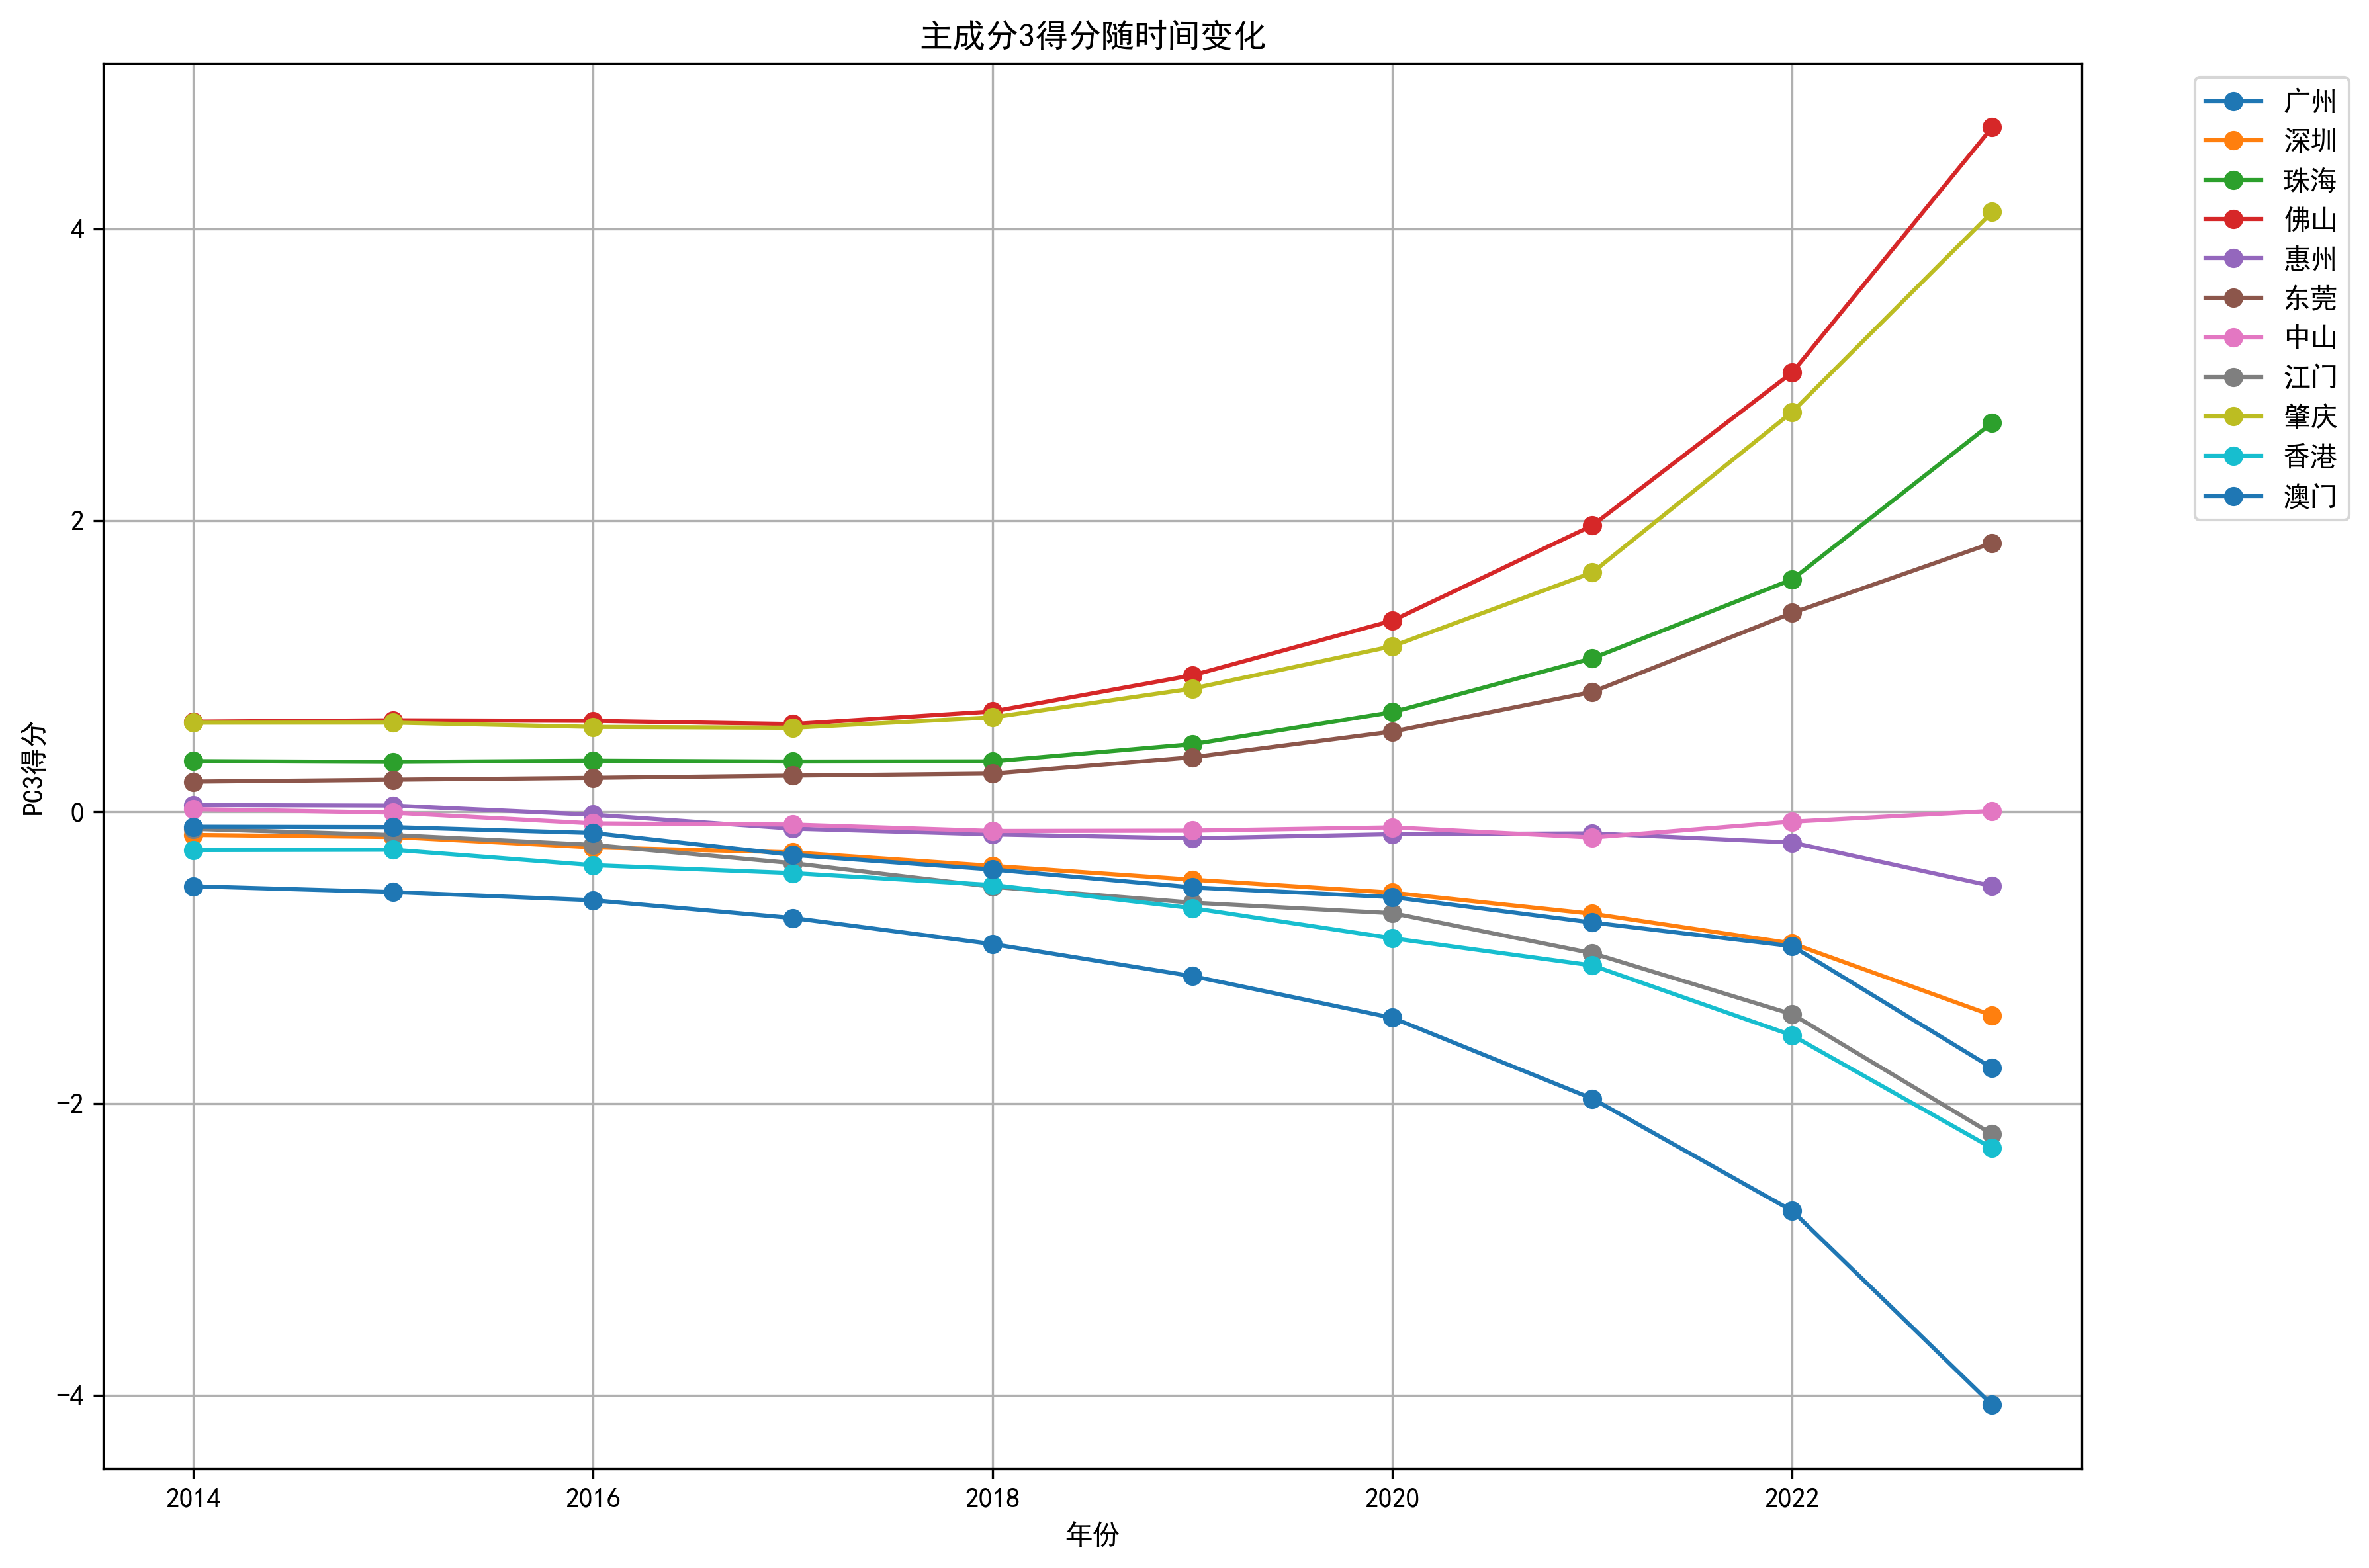

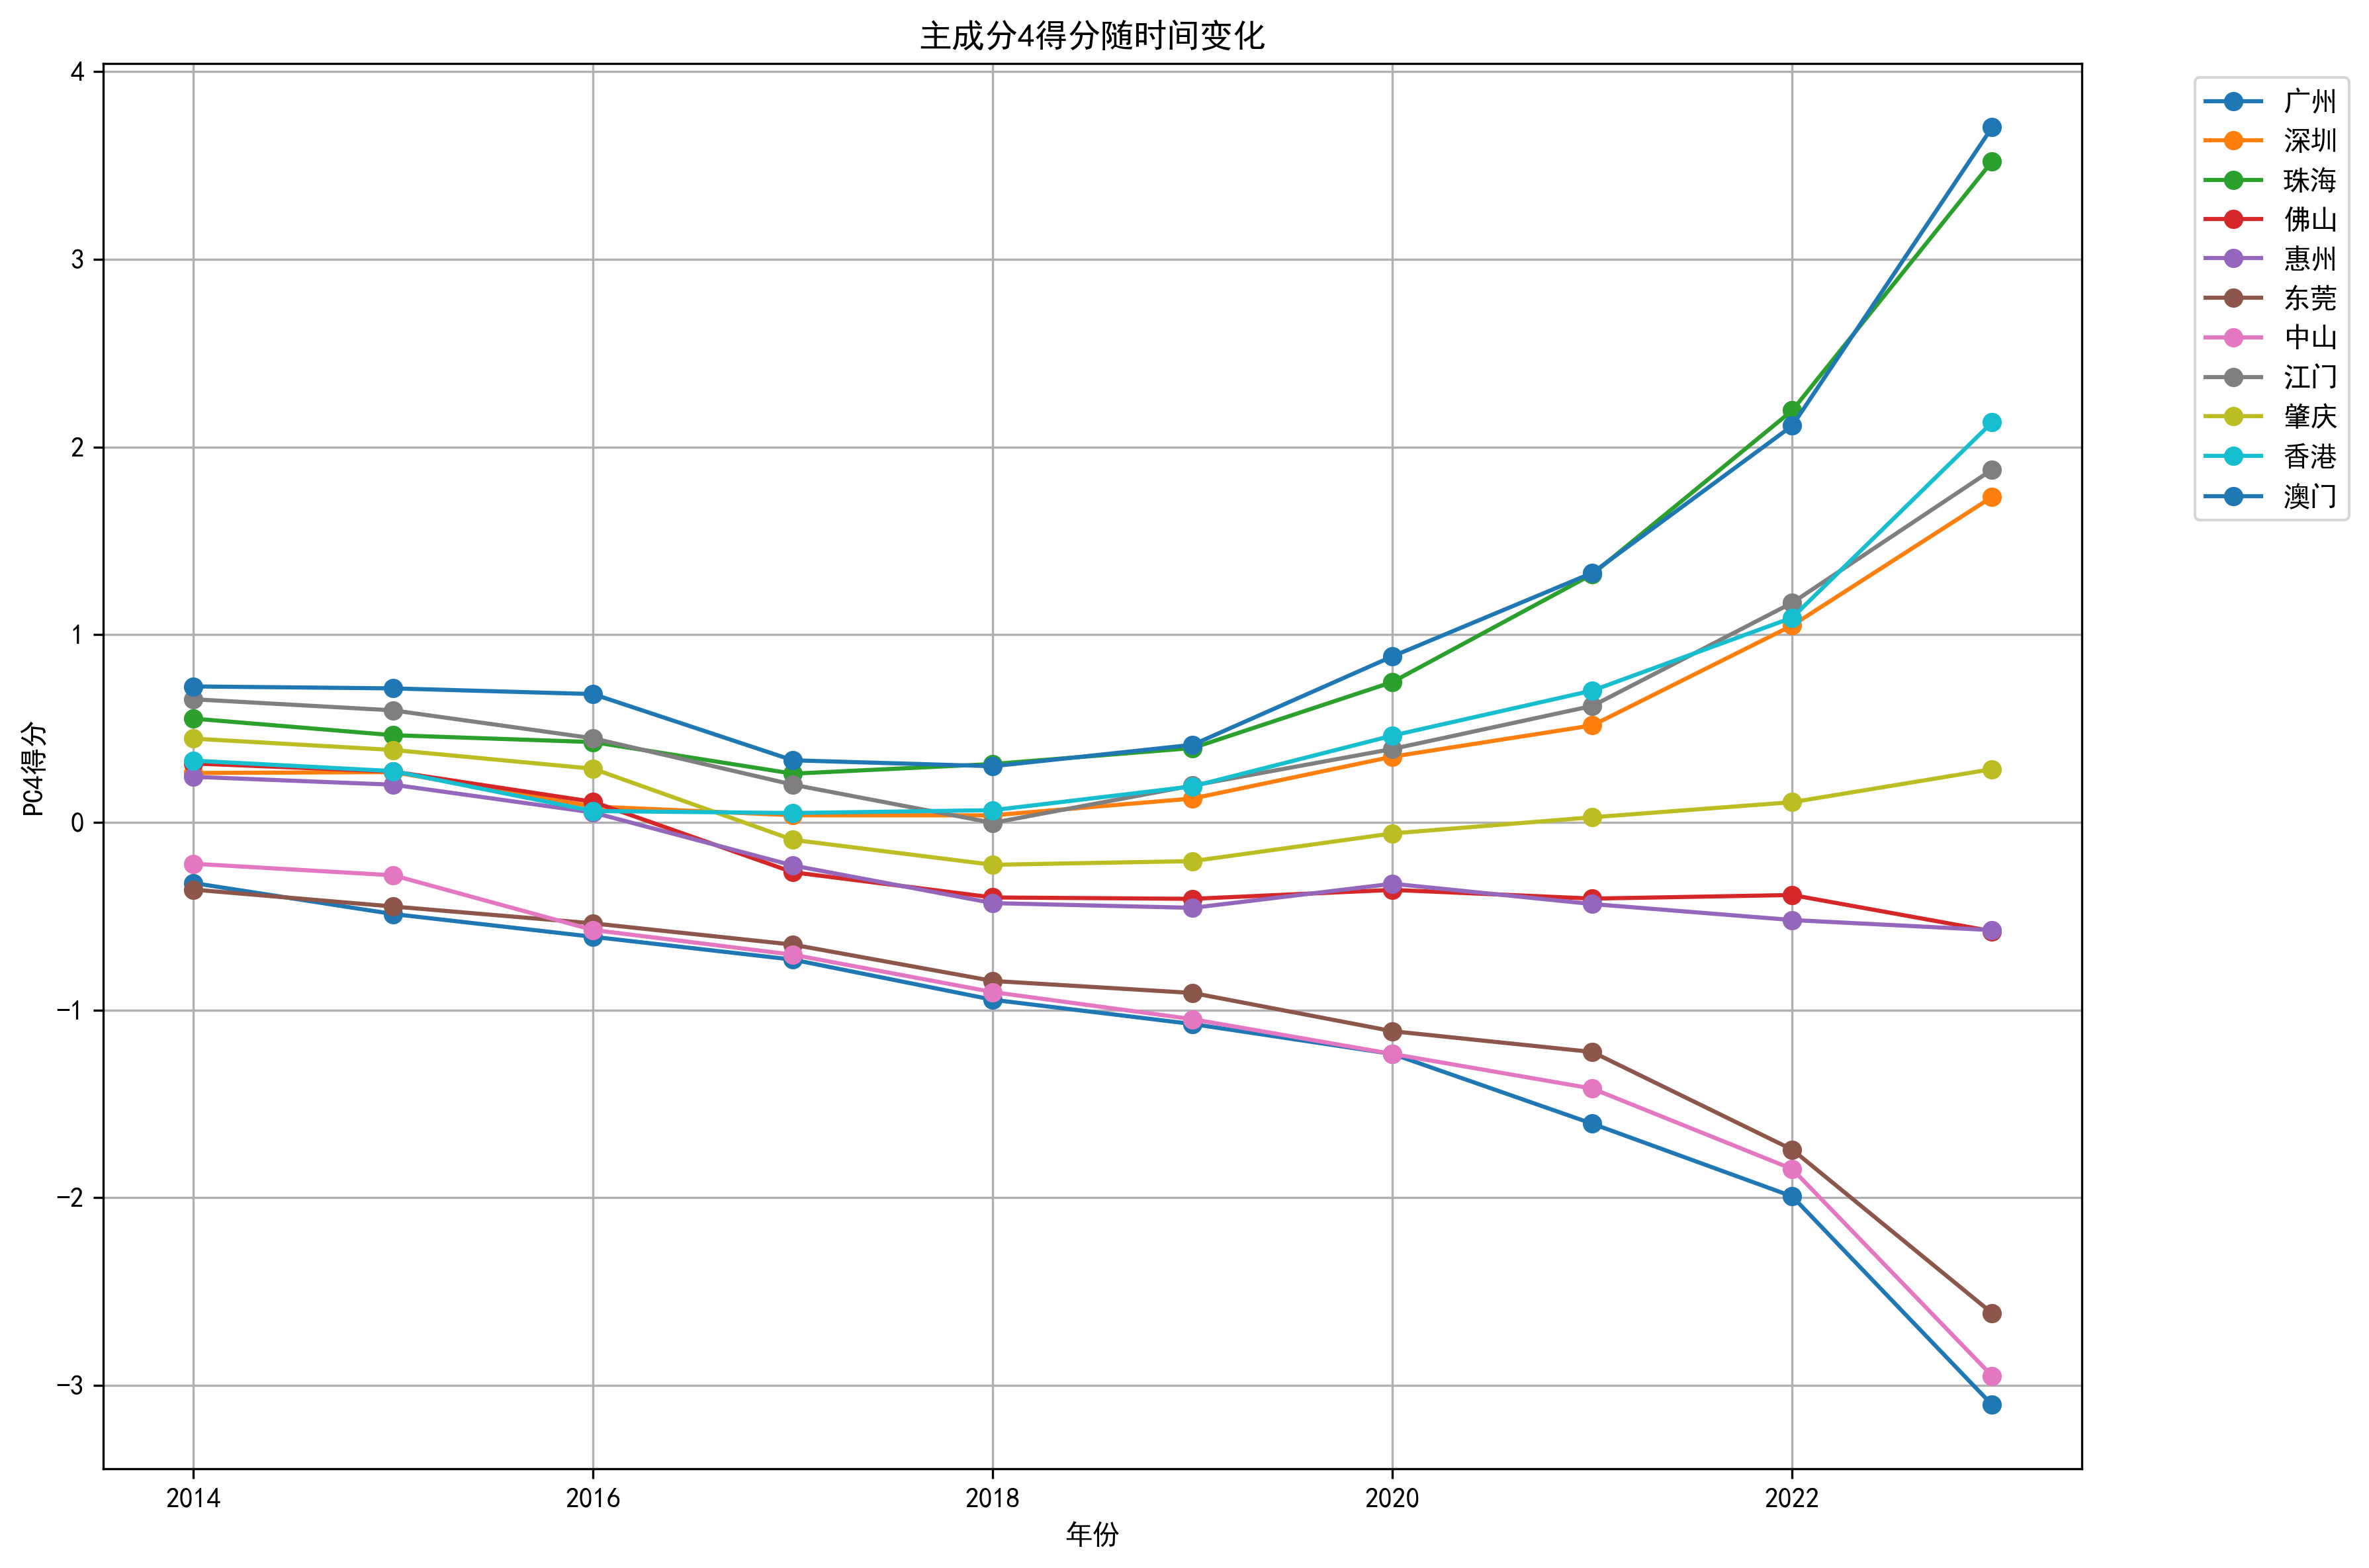

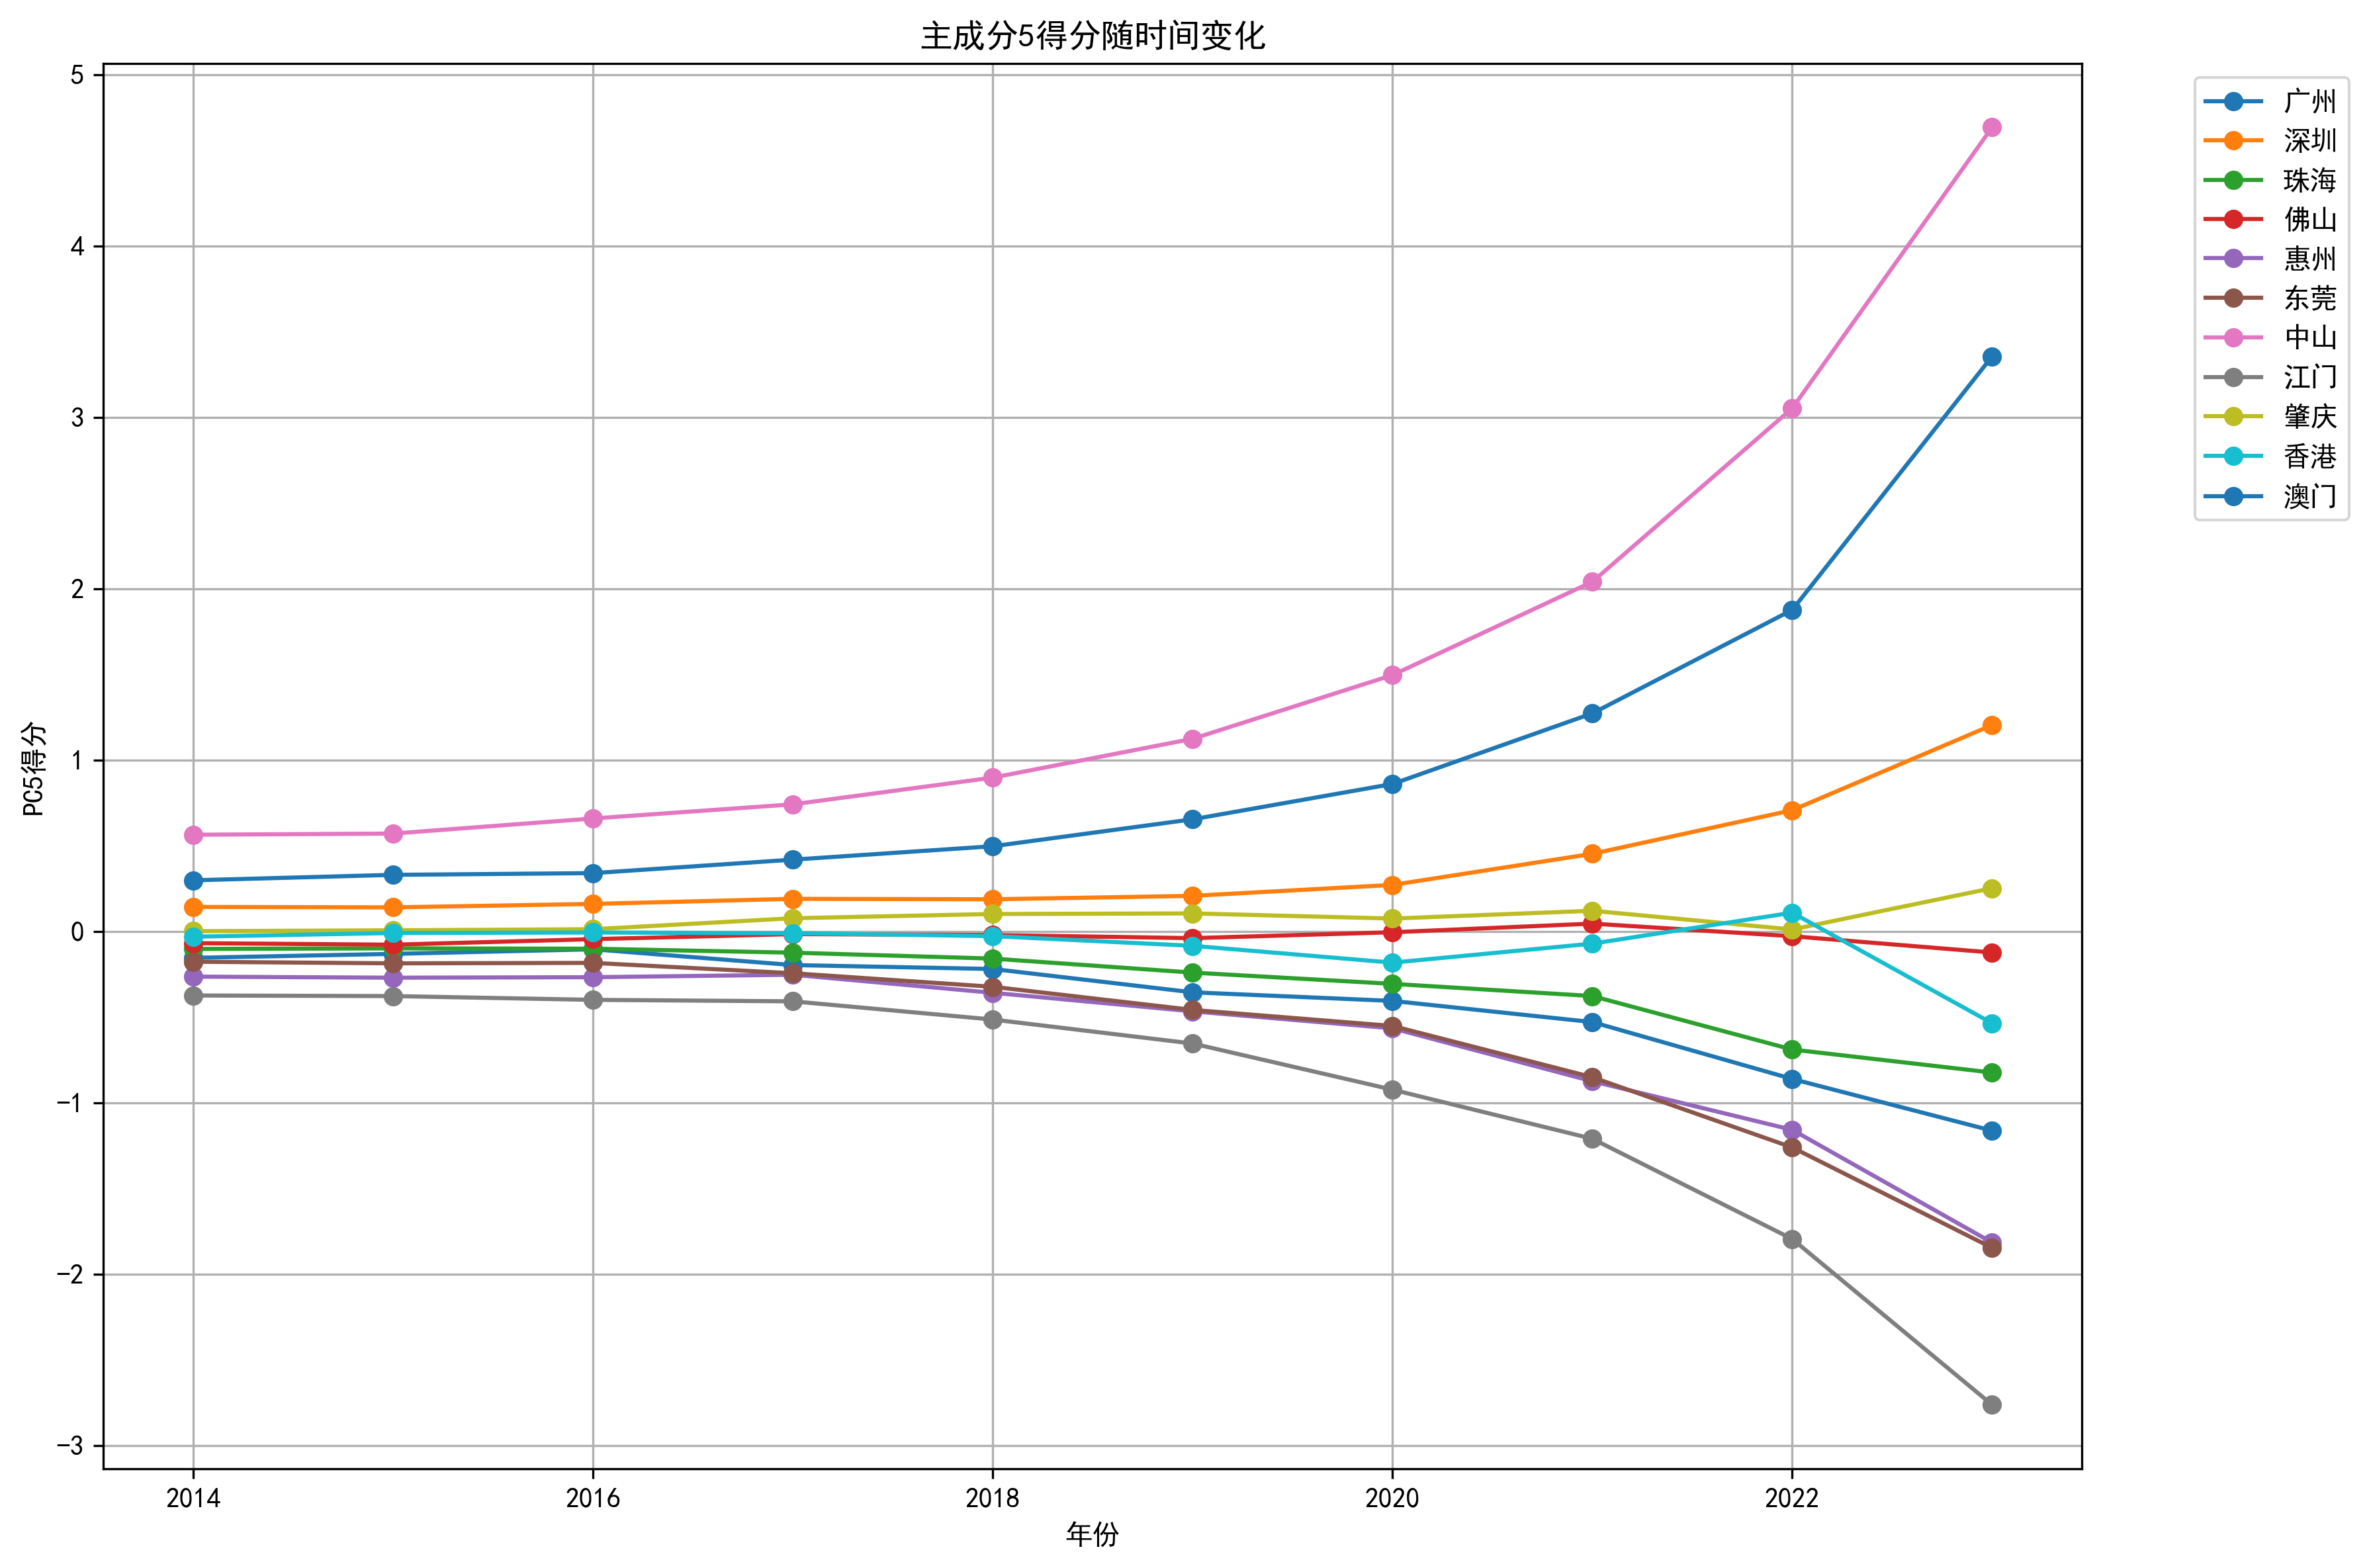

原创作者：B站北辰single，原创地址：https://www.yuque.com/u42168770/qv6z0d/eowuwbl8avfkbf8s


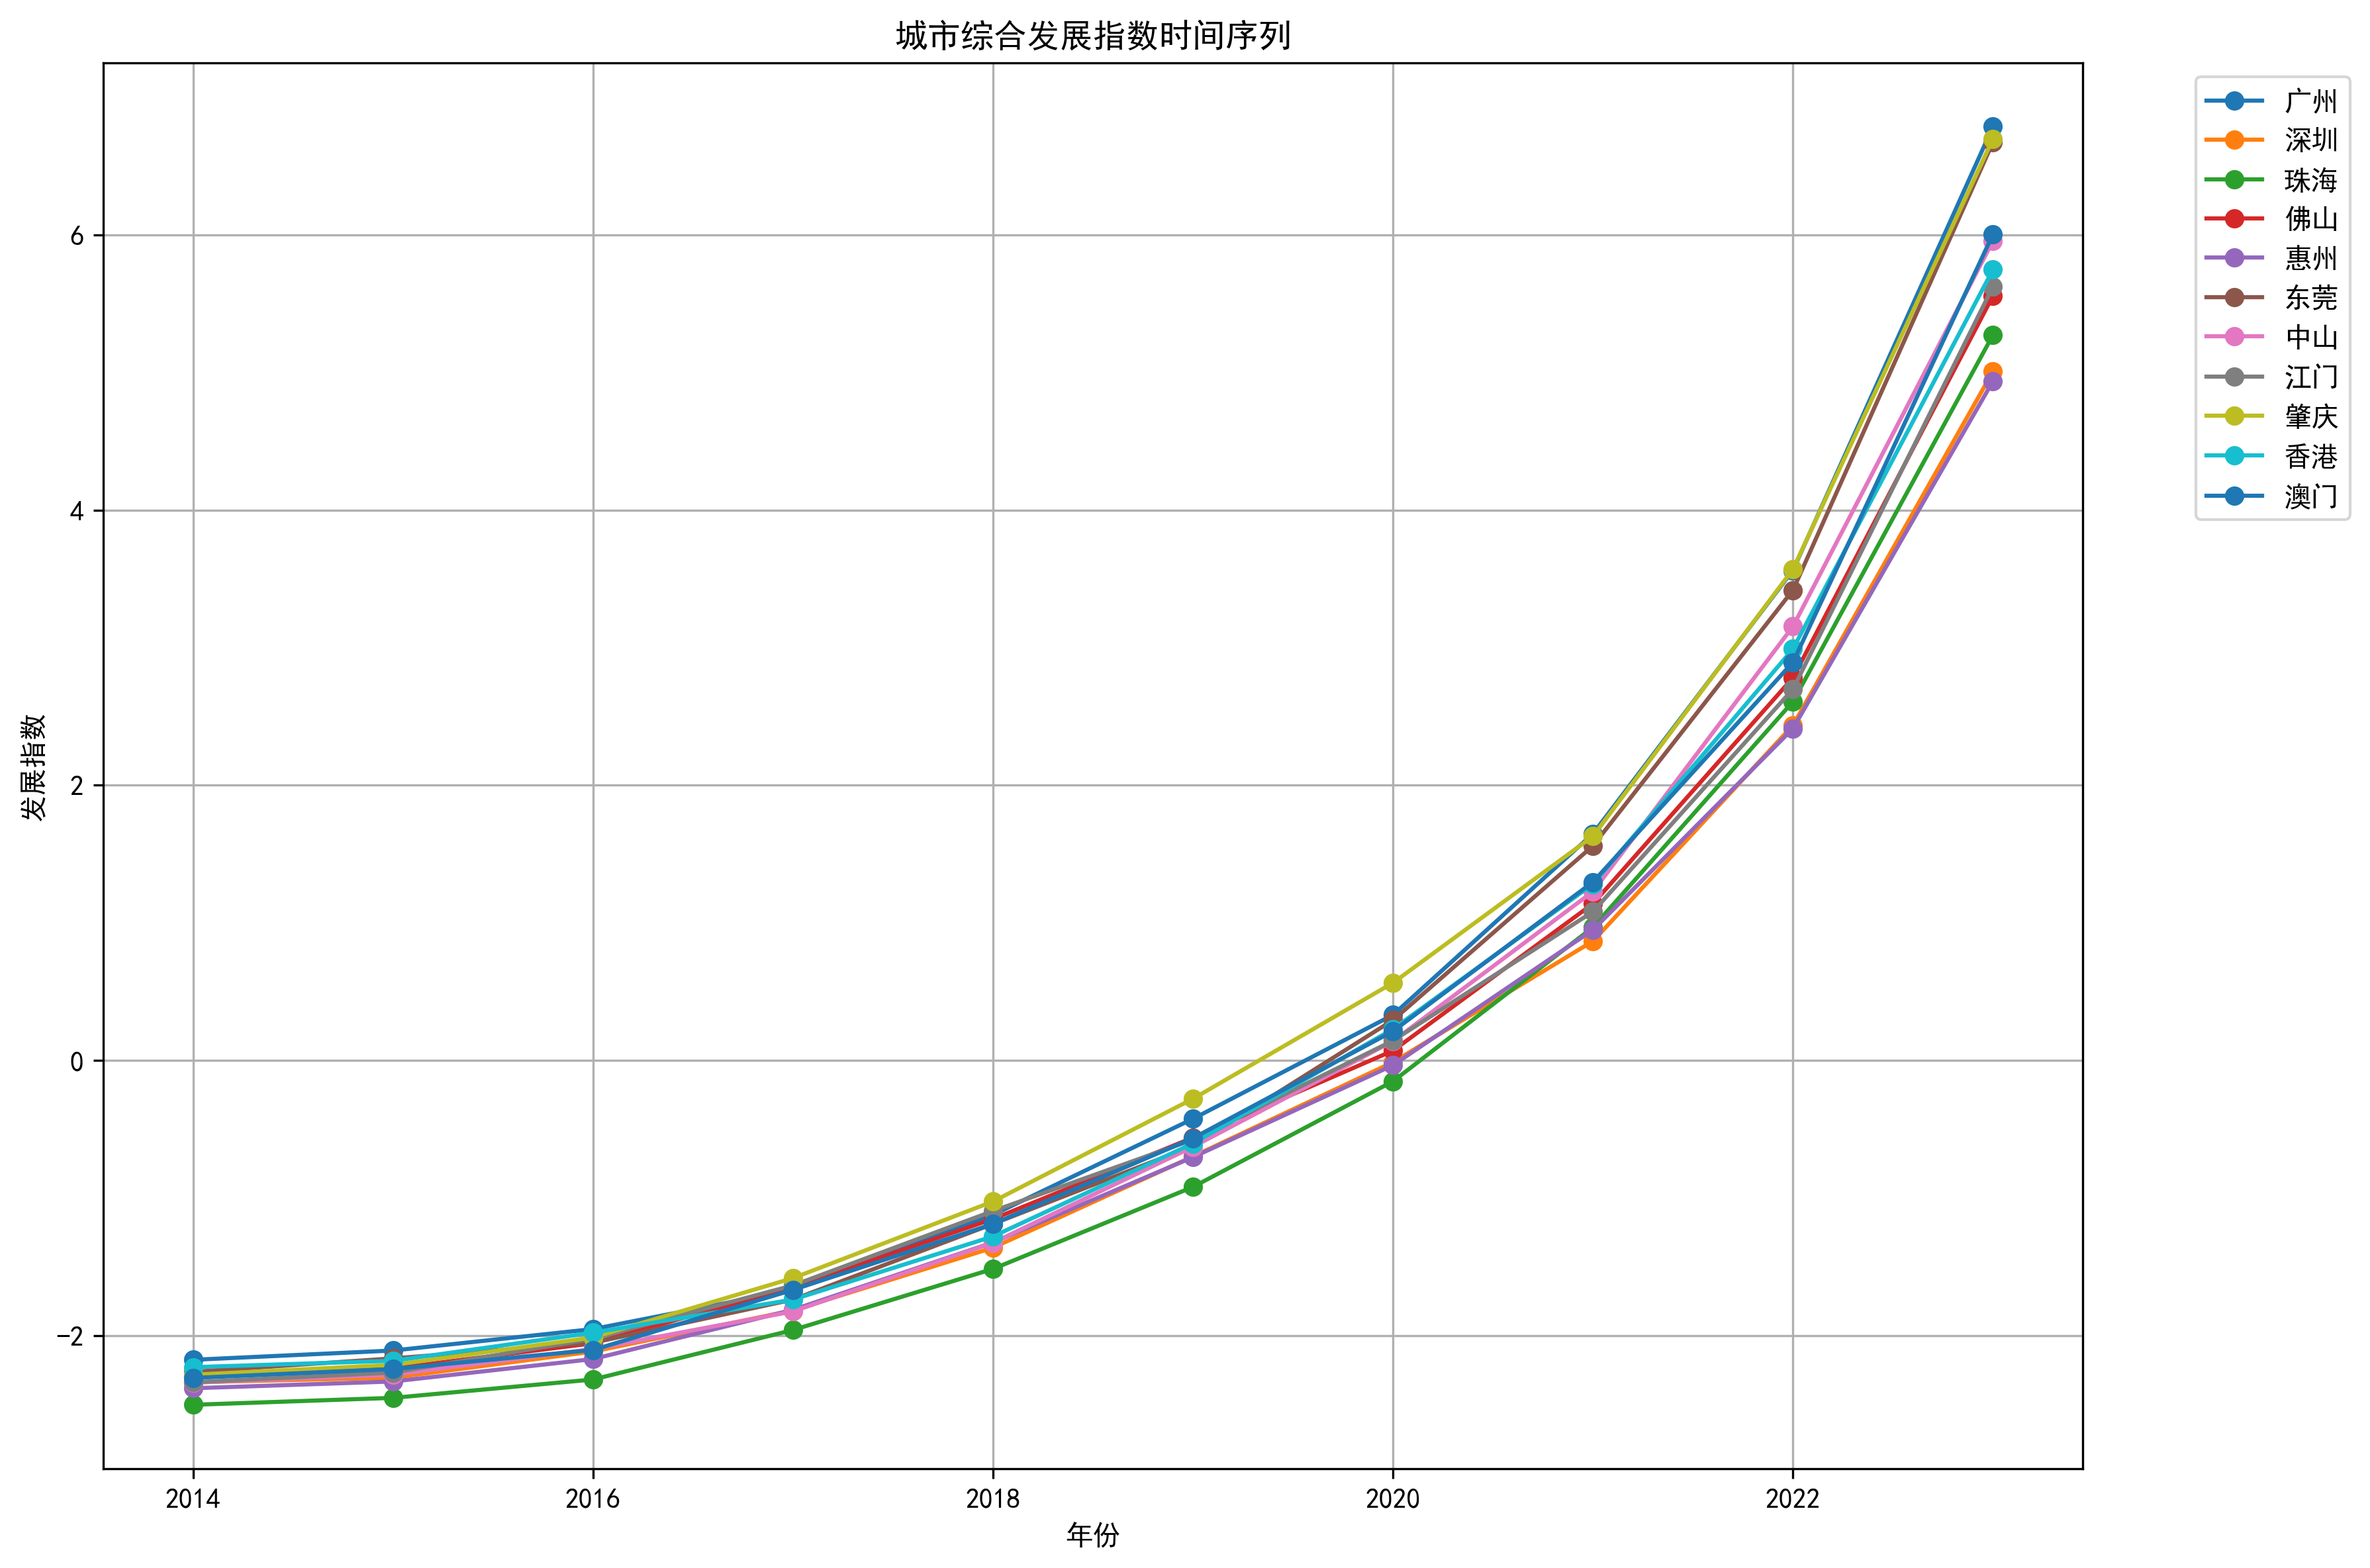


主成分分析结果：
累计贡献率：[0.64552657 0.72715859 0.78498115 0.83010956 0.86585152]

前三个主成分的主要影响因素：

PC1主要影响因素：
gdp_per_capita               0.233356
strategic_industry_output    0.226590
population                   0.218853
fixed_asset_investment       0.218807
rd_investment                0.216922
Name: PC1, dtype: float64

PC2主要影响因素：
working_age_ratio           0.489986
internet_penetration        0.432797
tertiary_industry_ratio     0.421406
secondary_industry_ratio    0.393619
high_edu_ratio              0.261646
Name: PC2, dtype: float64

PC3主要影响因素：
international_routes      0.388226
patents                   0.381494
fixed_asset_investment    0.351816
hightech_enterprises      0.321507
population_density        0.309424
Name: PC3, dtype: float64

灰色关联度最高的5个因素：
                           correlation
large_enterprises             0.839275
population_density            0.832517
strategic_industry_output     0.823129
patents                       0.821097
fixed_asset_investment        0.81267

In [11]:
# 因素分级
def classify_factors(correlations):
    classifications = {
        '核心因素': [],
        '重要因素': [],
        '一般因素': []
    }
    
    for factor, corr in correlations.items():
        if corr >= 0.8:
            classifications['核心因素'].append((factor, corr))
        elif corr >= 0.6:
            classifications['重要因素'].append((factor, corr))
        else:
            classifications['一般因素'].append((factor, corr))
    
    return classifications

# 进行因素分级
factor_classifications = classify_factors(grey_corr_df['correlation'].to_dict())

# 保存分级结果
with open('问题1_因素分级结果.txt', 'w', encoding='utf-8') as f:
    for level, factors in factor_classifications.items():
        f.write(f"{level}：\n")
        for factor, corr in factors:
            f.write(f"{factor}: {corr:.4f}\n")
        f.write("\n")

# 可视化不同城市主成分得分随时间的变化
for i in range(n_components):
    plt.figure(figsize=(12, 8), dpi=300)
    for city in df['city'].unique():
        city_data = pca_scores[pca_scores['city'] == city]
        plt.plot(city_data['year'], city_data[f'PC{i+1}'], label=city, marker='o')
    
    plt.title(f'主成分{i+1}得分随时间变化')
    plt.xlabel('年份')
    plt.ylabel(f'PC{i+1}得分')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'问题1_主成分{i+1}时间序列.png', dpi=300, bbox_inches='tight')
    plt.show()

# 计算城市综合发展指数
weights = pca.explained_variance_ratio_[:n_components]
development_index = np.zeros(len(X_pca_final))
for i in range(n_components):
    development_index += weights[i] * X_pca_final[:, i]
print("原创作者：B站北辰single，原创地址：https://www.yuque.com/u42168770/qv6z0d/eowuwbl8avfkbf8s")
# 添加综合发展指数到原始数据中
df['development_index'] = development_index

# 计算各城市各年份的发展指数排名
rankings = df.pivot(index='year', columns='city', values='development_index')

# 保存发展指数排名
rankings.to_excel('问题1_城市发展指数排名.xlsx')

# 绘制城市发展指数时间序列图
plt.figure(figsize=(12, 8), dpi=300)
for city in df['city'].unique():
    city_data = df[df['city'] == city]
    plt.plot(city_data['year'], city_data['development_index'], label=city, marker='o')

plt.title('城市综合发展指数时间序列')
plt.xlabel('年份')
plt.ylabel('发展指数')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('问题1_城市发展指数时间序列.png', dpi=300, bbox_inches='tight')
plt.show()

# 输出关键分析结果
print("\n主成分分析结果：")
print(f"累计贡献率：{cumulative_ratio[:n_components]}")
print("\n前三个主成分的主要影响因素：")
for i in range(min(3, n_components)):
    top_features = loadings[f'PC{i+1}'].abs().sort_values(ascending=False)[:5]
    print(f"\nPC{i+1}主要影响因素：")
    print(top_features)

print("\n灰色关联度最高的5个因素：")
print(grey_corr_df.head())
print("原创作者：B站北辰single，原创地址：https://www.yuque.com/u42168770/qv6z0d/eowuwbl8avfkbf8s")
print("\n各层次因素数量：")
for level, factors in factor_classifications.items():
    print(f"{level}: {len(factors)}个")

In [12]:
print("原创作者：B站北辰single，原创地址：https://www.yuque.com/u42168770/qv6z0d/eowuwbl8avfkbf8s")

原创作者：B站北辰single，原创地址：https://www.yuque.com/u42168770/qv6z0d/eowuwbl8avfkbf8s
